<a href="https://colab.research.google.com/github/MariiaS/moml/blob/main/V3_spectral_clustering2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***1/ Initialisation data reduced***

***We will use for our clustering the Shi & Malik method with multiple eigenvectors. Recurrent bi-partitioning being inefficient insofar as it is difficult to obtain a very separated graph between the two smallest eigenvectors. This is due to the fact that we have noisy datas.***

To avoid problems launch with colab 

## ***Create a 2D small dataset***

In [15]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import networkx as nx
import scipy as sy
import sklearn as sk
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
 
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors
#K-means
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [16]:
!wget -O dataset.csv https://www.openml.org/data/get_csv/49817/wine_quality.arff

--2020-11-30 10:56:27--  https://www.openml.org/data/get_csv/49817/wine_quality.arff
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘dataset.csv’

dataset.csv             [  <=>               ] 340.28K   892KB/s    in 0.4s    

2020-11-30 10:56:28 (892 KB/s) - ‘dataset.csv’ saved [348451]



 ***1) This example is there, to make clustering more visual. We have therefore chosen two features for a 2D representation.We made a clustering with all features on an other notebook.***

In [17]:
datas = pd.read_csv('dataset.csv')

In [18]:
datas_reduced = datas[0:200]
datas_reduced

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
195,7.8,0.590,0.33,2.0,0.074,24.0,120.0,0.9968,3.25,0.54,9.4,5
196,7.3,0.580,0.30,2.4,0.074,15.0,55.0,0.9968,3.46,0.59,10.2,5
197,11.5,0.300,0.60,2.0,0.067,12.0,27.0,0.9981,3.11,0.97,10.1,6
198,5.4,0.835,0.08,1.2,0.046,13.0,93.0,0.9924,3.57,0.85,13.0,7


***2) We chose the first two colomnes***

In [19]:
np_datas = datas_reduced.to_numpy()
np_datas_2D = np_datas[:,0:2]

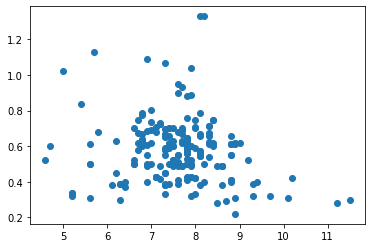

In [20]:
plt.scatter(np_datas_2D[:,0],np_datas_2D[:,1])

## ***Doing the first matrice with euclidian distances***

### ***function for euclidian***

***1) We do the adjacency matrix with the euclidian norm***

In [21]:
def euclidian_distance(line1,line2):
  #here we do the squared of the difference between two lines
  line = (line1-line2)*np.transpose((line1-line2))
  #We do the sum on the line to obtain the euclidian norm
  nombre = sum(line)
  return np.sqrt(nombre);

In [22]:
#  print(np_datas_2D)

### ***adjacency matrix***

***The following code is there to create the adjacency matrix.
We start by making a full square matrix of 0 with the dimension of the dataset.***

***After that we browse along the matrix to calculate the euclidian norm. we use a double "for" loop. We calculate the distance for the upper part of the matrix because it is symmetrical. And we just copy past the transpose to have the all matrix.***

In [23]:
A = np.zeros((len(np_datas_2D),len(np_datas_2D)))
for i in range(len(np_datas_2D)):
  for j in range(len(np_datas_2D)):
    if j > i :
      A[i][j]=euclidian_distance(np_datas_2D[i],np_datas_2D[j])
A = A + np.transpose(A)
print(A)      
A.mean()

[[0.         0.43863424 0.40447497 ... 4.11946598 2.00455107 0.63411355]
 [0.43863424 0.         0.12       ... 3.74518357 2.40042184 0.92417531]
 [0.40447497 0.12       0.         ... 3.72848495 2.40117159 0.95859272]
 ...
 [4.11946598 3.74518357 3.72848495 ... 0.         6.12341612 4.667344  ]
 [2.00455107 2.40042184 2.40117159 ... 6.12341612 0.         1.52152062]
 [0.63411355 0.92417531 0.95859272 ... 4.667344   1.52152062 0.        ]]


1.1273453454203946

## ***Epsilon graph***

### ***function for the weights***

***We transform the contiguity matrix to have an epsilon graph. We thus build here our matrix W (named A because we re-use the matrix of contiguity). For sigma, we chose 0.1 because we want to have a distinct demarcation between the points. A small sigma means that the values will be more spaced out on the epsilon graph. To find our epsilon we did several tests to see what gave a nice clustering. This is a delicate step because it greatly influences the number of clusters and the quality of the clustering. We chose it arbitrarily because we had no real method in the course to determine it. We have therefore taken the average of the values of the adjacency matrix divided by 3.***

In [24]:
#sigma defines the gap between the points on the graph (scale)
sigma = 0.1
meanA = A.mean()
epsilon = meanA/3
for i in range(len(np_datas_2D)):
  for j in range(len(np_datas_2D)):
    if A[i][j] < (epsilon):
      n = A[i][j]
      A[i][j] = np.exp(-n**2/(2*sigma))
    else : 
      A[i][j] = 0 
print(A)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.9305309 ... 0.        0.        0.       ]
 [0.        0.9305309 1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        0.       ]
 [0.        0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 0.        0.        1.       ]]


### ***Graph***

***We have drawn the epsilon graph. We can already see groups of points appear which can help us to select the number k of clusters. We can deduce that our epsilon is a little bit too small because our graph is already partially cut.Indeed the next step is to carry out an "egeingap" to know the number of cluster. We can check if what we find is consistent with respect to the epsilon graph.***

EdgeDataView([(0, 0, {'weight': 1.0}), (0, 4, {'weight': 1.0}), (0, 5, {'weight': 0.9920319148370607}), (0, 7, {'weight': 0.9394130628134754}), (0, 9, {'weight': 0.7788007830714052}), (0, 11, {'weight': 0.7788007830714052}), (0, 18, {'weight': 0.9412937690184057}), (0, 21, {'weight': 0.5063637471859784}), (0, 26, {'weight': 0.5376755326077269}), (0, 28, {'weight': 0.6373094172361978}), (0, 39, {'weight': 0.6959343136786418}), (0, 40, {'weight': 0.6959343136786418}), (0, 42, {'weight': 0.7629978999962201}), (0, 54, {'weight': 0.6835195639761816}), (0, 55, {'weight': 0.6175470617646803}), (0, 57, {'weight': 0.9282074740589837}), (0, 59, {'weight': 0.588310740756876}), (0, 61, {'weight': 0.6373094172361995}), (0, 62, {'weight': 0.8089646975665002}), (0, 64, {'weight': 0.8161762130223396}), (0, 65, {'weight': 0.8161762130223396}), (0, 66, {'weight': 0.8089646975665002}), (0, 70, {'weight': 0.6221960767418426}), (0, 71, {'weight': 0.6347652712514179}), (0, 72, {'weight': 0.6373094172361995}

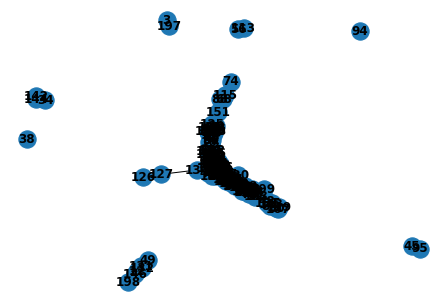

In [25]:
G = nx.from_numpy_matrix(A)
nx.draw(G,with_labels=True,
        font_weight='bold',
       )
G.edges(data=True) 

# ***2/ Calculs on laplacian***

## ***Calcul of the normalized laplacian method from networkx***

***We compute here the normalized laplacian. We use networkx library. We have to work with networkx graph format and not numpy array. It is possible to code the normalized laplacian with numpy but this is not optimized.***

> the code is :
`Ls = np.dot(np.dot(np.sqrt(np.linalg.inv(D)),L),np.sqrt(np.linalg.inv(D)))`

***Is it possible to use others normalisation for exemple the Random walk normalized Laplacian : Lnorm = D^-1.L***


In [26]:
Ls_nx = nx.normalized_laplacian_matrix(G)
G2 = nx.Graph(Ls_nx)
Ls = nx.to_numpy_array(G2)

## **Calcul of eigenvalues and vectors**

***Here we want to determine the number of cluster k. The most stable clustering is generally given by the value k wich represent the last "small" eigenvalue***

In [27]:
l, V = np.linalg.eig(Ls)
ind = np.argsort(l)
l = l[ind]
V = V[:,ind]

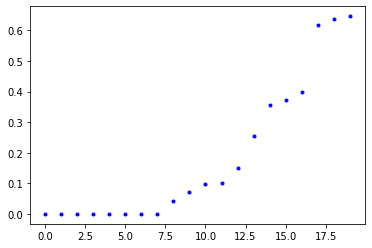

In [28]:
plt.plot(l[0:20],'b.')

### ***number of cluster selection***

***Thanks to the graph we can see that k is 8. Now we select the first 8 eigenvectors. An eigenvector associated with an eigenvalue equal to 0 in fact represents a cluster. The 8 vectors are therefore linearly independent. If a point is not connected to the cluster, its value in the eigenvector will be 0.
By selecting the first 8 eigenvectors we therefore have information on the content of each clusters.***

In [29]:
nb_cluster = 8
V_nb_clusters = V[:,0:nb_cluster-1]
# V_nb_clusters


# ***3/ K-mean***

## ***Training***

***Now we will do K_mean clustering on our eigenvectors data set.***


> ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.


In [30]:
kmeans = KMeans(init = "k-means++",n_clusters=nb_cluster)
knn_clusters = kmeans.fit_predict(np.real(V_nb_clusters))
labels = kmeans.labels_
labels

array([7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 0, 7, 1, 7, 0, 0, 0, 7, 7, 7, 0, 7,
       7, 0, 0, 0, 7, 7, 7, 7, 0, 7, 0, 7, 6, 7, 7, 7, 4, 7, 7, 0, 7, 7,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7, 7, 5, 7, 7, 7, 0, 7, 7, 7, 7, 7,
       7, 0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 7, 0, 7,
       0, 7, 7, 0, 0, 7, 3, 0, 0, 7, 0, 7, 0, 7, 7, 7, 7, 7, 7, 0, 7, 7,
       7, 0, 0, 5, 7, 0, 7, 7, 0, 7, 0, 0, 7, 7, 7, 0, 0, 0, 7, 0, 7, 1,
       1, 0, 0, 0, 0, 7, 7, 7, 0, 0, 6, 0, 6, 7, 1, 7, 7, 0, 7, 0, 7, 7,
       7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 0, 0, 0, 0, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 2,
       1, 0], dtype=int32)

***We link each label to its ID in the starting dataset.***

In [31]:
datas_reduced["k_means"] = labels
datas_reduced.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,k_means
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,7
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,7
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,7
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,7


***We can see clusters averages values. This doesn't really give us any information in a spectral clustering, because the clusters are in the shape of a circle.***

In [32]:
a = datas_reduced.groupby("k_means").mean()
print(a)

         fixed.acidity  volatile.acidity  ...    alcohol   quality
k_means                                   ...                     
0              7.82029          0.596159  ...   9.872464  5.202899
1              5.60000          0.573333  ...  11.350000  5.333333
2             11.35000          0.290000  ...   9.950000  6.000000
3              5.00000          1.020000  ...  10.500000  4.000000
4              5.70000          1.130000  ...   9.800000  4.000000
5             10.15000          0.365000  ...   9.650000  5.500000
6              5.20000          0.333333  ...  12.400000  5.666667
7              7.55431          0.567543  ...   9.683621  5.284483

[8 rows x 12 columns]


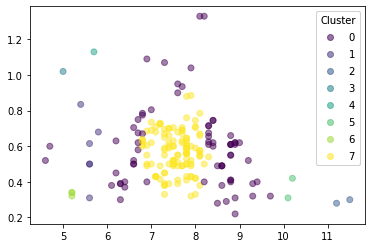

In [33]:
fig, ax = plt.subplots()

scatter = ax.scatter(np_datas_2D[:,0], np_datas_2D[:,1], c = labels.astype(np.float),alpha = 0.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Cluster")
ax.add_artist(legend1)
plt.show()

# ***4/ Silhouette analisys***

***We are now going to do a silhouette analysis on our k_mean. Silhouette coefficient is the difference between the average distance with the points of the same group as it and the average distance with the points of the other neighboring groups. It is not really relevant in our case because our clusters have ring shapes. Which means that the coefficient will be bad for the clusters outside the center.***

In [34]:
score = sk.metrics.silhouette_score(np.real(V_nb_clusters), kmeans.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.593


In [35]:
score = sk.metrics.silhouette_score(np_datas_2D, kmeans.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.280


In [36]:
sample_silhouette_values = sk.metrics.silhouette_samples(np_datas_2D, kmeans.labels_, metric='euclidean')
print(sample_silhouette_values)

[ 0.64912624  0.52382826  0.58441953  0.71503041  0.64912624  0.66065182
  0.5815773   0.63873679  0.64080343  0.68349063 -0.38629394  0.68349063
  0.57381522  0.63681425  0.04966395  0.04966395 -0.0990428   0.4297639
  0.67229499  0.52906277 -0.03295027  0.65069892  0.56766174 -0.0826834
 -0.4749286  -0.56373542  0.6579334   0.56766174  0.5513963   0.62868565
 -0.38139498  0.45511677 -0.24190195  0.47293603  0.96035149  0.62868565
  0.63853006  0.41031149  0.          0.63814393  0.63814393  0.08223691
  0.68168397  0.41788464 -0.429466   -0.80827199 -0.53306989  0.01827362
 -0.48569631  0.1679446   0.07657195 -0.3434533  -0.34332153 -0.02195619
  0.68255295  0.66536298  0.87158293  0.67877316  0.63991464  0.62383081
  0.07320635  0.64686455  0.68591982  0.50167525  0.58719143  0.58719143
  0.68591982 -0.33942061 -0.4569286   0.48922585  0.66353187  0.65340006
  0.64686455 -0.24014975 -0.76608053  0.07448737  0.07448737 -0.41259433
 -0.37491458 -0.24476429 -0.64313912  0.61723034  0.6

In [37]:
for i in range(len(sample_silhouette_values)):
  if sample_silhouette_values[i] < 0:
    labels[i] = 0
labels

array([7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 0, 7, 1, 7, 0, 0, 0, 7, 7, 7, 0, 7,
       7, 0, 0, 0, 7, 7, 7, 7, 0, 7, 0, 7, 6, 7, 7, 7, 4, 7, 7, 0, 7, 7,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7, 7, 5, 7, 7, 7, 0, 7, 7, 7, 7, 7,
       7, 0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 7, 0, 7,
       0, 7, 7, 0, 0, 7, 3, 0, 0, 7, 0, 7, 0, 7, 7, 7, 7, 7, 7, 0, 7, 7,
       7, 0, 0, 5, 7, 0, 7, 7, 0, 7, 0, 0, 7, 7, 7, 0, 0, 0, 7, 0, 7, 1,
       1, 0, 0, 0, 0, 7, 7, 7, 0, 0, 6, 0, 6, 7, 1, 7, 7, 0, 7, 0, 7, 7,
       7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 0, 0, 0, 0, 7, 7, 0, 0, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 2,
       1, 0], dtype=int32)

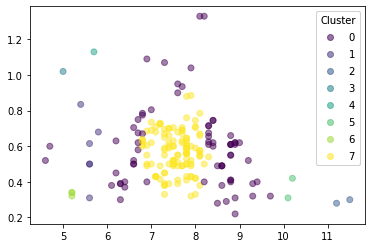

In [38]:
fig, ax = plt.subplots()

scatter = ax.scatter(np_datas_2D[:,0], np_datas_2D[:,1], c = labels.astype(np.float),alpha = 0.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Cluster")
ax.add_artist(legend1)
plt.show()

***As expected the values of the ring around the center are considered bad. However, they are relevant for a spectral clustering. The silhouette coefficient is therefore not useful for evaluating a spectral clustering. We can see that this is a method made to evaluate a k_mean clustering***